## Importation des bibliotheques

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import matplotlib.pyplot as plt
from timm import create_model
from torchsummary import summary
from sklearn.metrics import classification_report
import torch.nn.functional as F


## Verification du GPU

In [9]:
print("GPU disponible :", torch.cuda.is_available())
print("Nom du GPU :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun")


GPU disponible : True
Nom du GPU : Tesla T4


## Chargement et analyse des donnees

In [10]:
# Chemin du dossier principal
base_path = "/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset"

# Lister les sous-dossiers (classes)
classes = os.listdir(base_path)
print("Classes disponibles :", classes)

Classes disponibles : ['README.md', 'organized_plums_data_new.csv', 'african_plums']


In [11]:
# Chemin vers le dossier african_plums
plums_path = os.path.join(base_path, "african_plums")

# Vérification que le chemin existe
if not os.path.exists(plums_path):
    print("Erreur : Le dossier african_plums n'existe pas à l'emplacement spécifié.")
    print("Contenu du dossier african_plums_dataset :")
    print(os.listdir(base_path))
else:
    print("Dossier african_plums trouvé avec succès !")

Dossier african_plums trouvé avec succès !


In [12]:
if os.path.exists(plums_path):
    # Lister tous les sous-dossiers (classes)
    classes = [d for d in os.listdir(plums_path) 
              if os.path.isdir(os.path.join(plums_path, d))]
    
    print("\nNombre d'images par classe :")
    print("----------------------------")
    
    for class_name in classes:
        class_path = os.path.join(plums_path, class_name)
        num_images = len([f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        print(f"{class_name}: {num_images} images")


Nombre d'images par classe :
----------------------------
unripe: 826 images
cracked: 162 images
rotten: 720 images
spotted: 759 images
bruised: 319 images
unaffected: 1721 images


In [13]:
if os.path.exists(plums_path):
    # Préparer les données pour un DataFrame
    data = []
    
    for class_name in os.listdir(plums_path):
        class_path = os.path.join(plums_path, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            data.append({
                "Classe": class_name,
                "Nombre d'images": len(images),
                "Exemple de fichier": images[0] if images else "Aucune"
            })
    
    # Créer et afficher le DataFrame
    df = pd.DataFrame(data)
    print(df)
    
    # Statistiques supplémentaires
    print("\nTotal d'images:", df["Nombre d'images"].sum())

       Classe  Nombre d'images       Exemple de fichier
0      unripe              826      unripe_plum_644.png
1     cracked              162      cracked_plum_42.png
2      rotten              720      rotten_plum_584.png
3     spotted              759     spotted_plum_346.png
4     bruised              319     bruised_plum_144.png
5  unaffected             1721  unaffected_plum_970.png

Total d'images: 4507


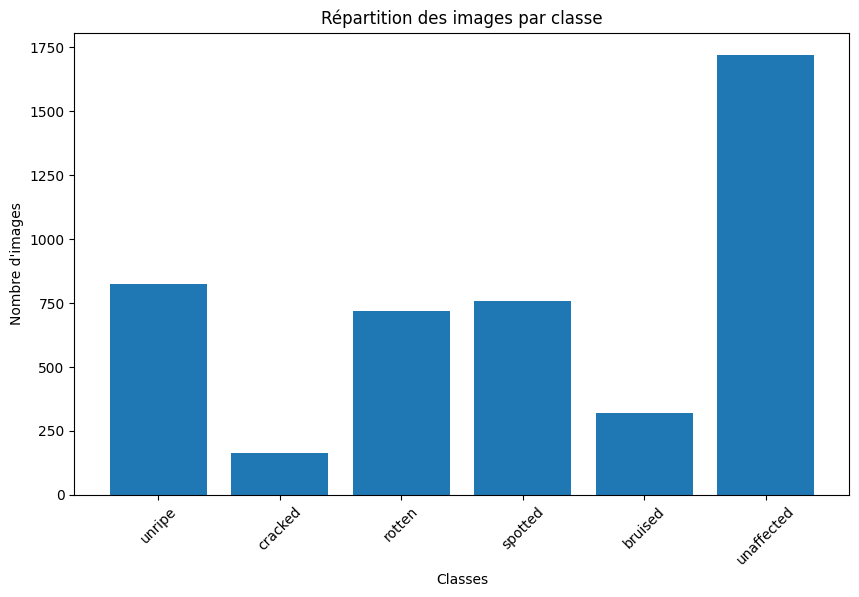

In [14]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    plt.bar(df["Classe"], df["Nombre d'images"])
    plt.title("Répartition des images par classe")
    plt.xlabel("Classes")
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=45)
    plt.show()

## Decoupage train val test

In [19]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Dossier source
source_dir = "/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums"
# Dossier de destination
split_dir = "/kaggle/working/african_plums_split"

# Création des dossiers train, val, test
for split in ["train", "val", "test"]:
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(split_dir, split, class_name), exist_ok=True)

# Split des données
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(split_dir, "train", class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(split_dir, "val", class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(split_dir, "test", class_name, img))

print("✅ Split terminé et dossiers créés avec succès.")


✅ Split terminé et dossiers créés avec succès.


## Étape 2 : Data Augmentation (standard + ciblée pour les classes minoritaires)

In [21]:
from torchvision import transforms
import torch
from collections import Counter
from torchvision.datasets import ImageFolder

IMG_SIZE = 224

# Base transform
base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Augmentation avancée
augmented_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomRotation(20),
    base_transform
])

# Classe qui applique plus d’augmentation aux classes minoritaires
class BalancedAugmentedDataset(ImageFolder):
    def __getitem__(self, index):
        path, label = self.samples[index]
        image = self.loader(path)
        
        # Classe minoritaire ? Augmente + souvent
        if self.class_to_idx[self.classes[label]] in self.minority_classes:
            if torch.rand(1) < 0.75:
                return augmented_transform(image), label
        # Classe majoritaire
        if torch.rand(1) < 0.5:
            return augmented_transform(image), label
        else:
            return base_transform(image), label

# Analyse du déséquilibre pour trouver les classes minoritaires
train_dataset_raw = ImageFolder(train_dir)
class_counts = Counter([label for _, label in train_dataset_raw.samples])
mean_count = np.mean(list(class_counts.values()))
minority_classes = [cls for cls, count in class_counts.items() if count < mean_count]

# Dataset final équilibré avec sur-augmentation
train_dataset = BalancedAugmentedDataset(train_dir)
train_dataset.minority_classes = minority_classes
train_dataset.transform = None  # On override __getitem__, pas besoin ici


## Étape 3 : Préparation des loaders (avec WeightedRandomSampler pour plus de robustesse)

In [35]:
from torch.utils.data import DataLoader, WeightedRandomSampler

BATCH_SIZE = 16

# Poids inversement proportionnels aux fréquences
targets = [label for _, label in train_dataset.samples]
class_sample_counts = np.bincount(targets)
weights = 1. / class_sample_counts[targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(ImageFolder(val_dir, transform=base_transform), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(ImageFolder(test_dir, transform=base_transform), batch_size=BATCH_SIZE, shuffle=False)


## Entrainement et evaluation

In [38]:
import timm
import torch
import torch.nn as nn

# Vérifier si CUDA est disponible et définir l'appareil (device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Déplacer le modèle sur le device
model = model.to(device)

# Lors de la boucle d'entraînement
for images, labels in train_loader:
    # Déplacer les données sur le même appareil que le modèle (GPU si disponible)
    images, labels = images.to(device), labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass et optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [ ]:
import time

# Early stopping setup
early_stopping_patience = 5  # Arrêter après 5 époques sans amélioration
best_val_acc = 0.0
epochs_without_improvement = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Entraînement
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculer la précision d'entraînement
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            # Calculer la précision de validation
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Calculer la perte et la précision moyenne
    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val

    # Enregistrer les valeurs pour l'affichage
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Afficher les métriques
    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {train_loss:.4f} - Acc: {train_acc:.4f} "
          f"- Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f} - Time: {epoch_time:.2f}s")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        # Sauvegarder le modèle
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered!")
            break
    
    # Scheduler
    scheduler.step()


Epoch [1/10] - Loss: 2.0157 - Acc: 0.1712 - Val Loss: 2.0796 - Val Acc: 0.1840 - Time: 75.82s
Epoch [2/10] - Loss: 1.9987 - Acc: 0.1740 - Val Loss: 2.0796 - Val Acc: 0.1840 - Time: 78.17s
Epoch [3/10] - Loss: 1.9894 - Acc: 0.1771 - Val Loss: 2.0796 - Val Acc: 0.1840 - Time: 76.12s
Epoch [4/10] - Loss: 2.0076 - Acc: 0.1651 - Val Loss: 2.0796 - Val Acc: 0.1840 - Time: 75.72s


In [ ]:
# Affichage des courbes de performance
plt.figure(figsize=(12, 6))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
